In [433]:
#Imports
import time
import random

import numpy as np
from scipy.stats import norm
import gurobipy as gb
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

#Set seed for reproducibility of instances
np.random.seed(25)

print_selections = False

def instance_generator(n=50000):
    '''
    Function that generates hard Knapsack problem instances.
    Input:
        -n: desired size of set of items I, defaulted at 50,000 as we use this number in our study
    Returns:
        -v: array of values for all i items
        -w: array of weights of all i items
    ''' 
    v = np.round(norm.rvs(100, 10, size=n))
    w = np.zeros(n)
    for i in range(n):
        w[i] = round(norm.rvs(v[i], 5))
    return v, w

v, w = instance_generator()

# Problem size set-up
N = [10, 25, 50, 100, 250, 500, 750, 1000, 1500]

# Capacity constraint function based on the problem size
def W(n):
    return round(0.45*np.sum(w[0:n]))

# Binary problem
def binary_method(n, v=v, w=w):
    '''
    Function that runs the Gurobi-binary problem.
    Input:
        -n: Input problem size
    Output:
        -obj_val: Outcome of the optimizatoin
        -running_time: Time to run the algorithm on the problem size
    '''
    # Selecting relevant i for problem size
    W_gb = W(n)

    start_time = time.time()

    m = gb.Model("Binary model")
    x = m.addVars(n, vtype=gb.GRB.BINARY, name="x")

    m.setObjective(gb.quicksum(v[i]*x[i] for i in range(n)), gb.GRB.MAXIMIZE)

    m.addConstr(gb.quicksum(w[i]*x[i] for i in range(n)) <= W_gb)

    m.update()
    m.Params.LogToConsole = 0
    m.optimize()
    
    obj_val = m.objVal
    running_time = time.time() - start_time
    selected_items = [i for i in range(n) if x[i].X == 1] 
    return obj_val, running_time, selected_items

optimal_solution_binary = [binary_method(n)[0] for n in N]
running_time_binary = [binary_method(n)[1] for n in N]
print(f"For n = {N}:")
print(f"Gurobi model optimal solution: {optimal_solution_binary}")
print(f"Gurobi model running times: {running_time_binary}")

if print_selections: 
    print(f"Gurobi model selected items:{[binary_method(n)[2] for n in N]}")

# Dynamic programming
def dyn_prog_method(n, v=v, w=w):
    
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_dp = int(W(n))

    # Start runtime measurement
    start_time = time.perf_counter()

    # Create table for bottom up dynamic programming
    OPT_table = [[0 for i in range(W_dp+1)] for i in range(n+1)]
    
    # Dynamic programming algorithm
    for i in range(1, n+1):
        for j in range(1, W_dp+1):
            if w[i-1] <= j:
                OPT_table[i][j] = max(OPT_table[i-1][j], v[i-1]+ OPT_table[i-1][int(j-w[i-1])])
            else:
                OPT_table[i][j] = OPT_table[i-1][j]

    # Backtrack to find the selected items
    selected_items = []
    j = W_dp
    for i in range(n, 0, -1):
        if OPT_table[i][j] != OPT_table[i - 1][j]:  # Item i-1 is included
            selected_items.append(i - 1)  # Add the index of the item
            j -= int(w[i - 1])  # Reduce the remaining capacity
    selected_items.reverse()  # Reverse the list to get the correct order

    # End runtime measurement
    running_time = time.perf_counter() - start_time

    # Return the value in the knapsack and the running time
    return OPT_table[n][W_dp], running_time, selected_items

optimal_solution_dp, running_time_dp, selected_items_dp = [], [], []
print("Warning: total DP analysis can be lengthy (around 2 minutes)")
for n in N:
    DP_sol = dyn_prog_method(n)
    optimal_solution_dp.append(DP_sol[0])
    running_time_dp.append(DP_sol[1])
    selected_items_dp.append(DP_sol[2])
    print(f"DP case N={n} analysed!")

print(f"For n = {N}:")
print(f"DP optimal solution: {optimal_solution_dp}")
print(f"DP running times: {running_time_dp}")
if print_selections:
    print(f"DP selected items: {selected_items_dp}")

# Greedy Hueristic
def greedy_heuristic(n, v=v, w=w):
    
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_gy = W(n)

    # Start runtime measurement
    start_time = time.perf_counter()

    # Calculate ratios
    ratios = [(v[i]/w[i], v[i], w[i]) for i in range(n) ]
    ratios.sort(reverse=True)

    # initialize empty knapsack
    weight_in_knapsack = 0
    value_in_knapsack = 0

    # fill up iteratively over items in ratio order
    for _, value, weight in ratios:
        if weight_in_knapsack + weight <= W_gy:
            value_in_knapsack += value
            weight_in_knapsack += weight

    # End runtime measurement
    running_time = time.perf_counter() - start_time

    # Return the value in the knapsack and the running time
    return value_in_knapsack, running_time

optimal_solution_gh = [greedy_heuristic(n)[0] for n in N]
running_time_gh = [greedy_heuristic(n)[1] for n in N]
print(f"For n = {N}:")
print(f"GH optimal solution: {optimal_solution_gh}")
print(f"GH running times: {running_time_gh}")  

KeyboardInterrupt: 

RL AGENT

In [435]:
# RL Agent

# Define the device (using GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# New capacity constraint function for the neural network based on the problem size
def W(n,w_input):
    return round(0.45*np.sum(w_input[0:n]))


In [451]:


class NeuralNetworkAgent(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128):
        super(NeuralNetworkAgent, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, 1)  # Output a single Q-value per row

        # Activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        # Pass input through the fully connected layers with ReLU activation
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))


        # Output layer (produces a single Q-value per input)
        qvalue = self.fc6(x).squeeze(-1)  # Remove last dimension for proper Q-value shape

        return qvalue


In [356]:
# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity=1024):
        self.buffer = []
        self.capacity = capacity

    def push(self, transition):
        if len(self.buffer) > self.capacity:
            del self.buffer[0]
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [457]:

# Knapsack environment created through class
class Knapsack_environment:
    def __init__(self, v=[0,1] , w=[0,1], capacity=10, max_items=10, new_input=True):
        self.v = v # concatenate allows for later adaptation of amount of training set items
        self.w = w
        self.capacity = capacity
        self.free = np.full(len(v), capacity)
        self.selected = np.zeros(len(v))
        self.reset(len(v), new_input = new_input)

    # Re-set knapsack to empty for new problem
    def reset(self, N_items, new_input=True):
        
        if new_input:
            self.v, self.w = instance_generator(N_items)
            self.capacity = W(N_items, self.w)

        self.ratios = self.v / self.w
        self.free = np.full(N_items, self.capacity)
        self.preselected = np.zeros(N_items)
        self.preselected[self.w > self.free] = 1 # add item to list of pre-selected items
        
        reward = 0
        return self.get_state()
    
    def get_state(self):
        # Step 1: Sort by 'preselected' to move preselected=1 items to the bottom
        preselected_sort_indices = np.argsort(self.preselected)

        # Apply the preselected sorting to all arrays
        self.v = self.v[preselected_sort_indices]
        self.w = self.w[preselected_sort_indices]
        self.ratios = self.ratios[preselected_sort_indices]
        self.preselected = self.preselected[preselected_sort_indices]

        # Step 2: Now sort by 'ratios' within the group where preselected=0 (i.e., non-preselected)
        sorted_indices = np.argsort(self.ratios[self.preselected == 0])[::-1]

        # Re-apply sorting to only the non-preselected items
        self.v[self.preselected == 0] = self.v[self.preselected == 0][sorted_indices]
        self.w[self.preselected == 0] = self.w[self.preselected == 0][sorted_indices]
        self.ratios[self.preselected == 0] = self.ratios[self.preselected == 0][sorted_indices]


        return np.vstack([self.v, self.w, self.ratios, self.free, self.preselected]).T

    def step(self, action, value_knap):
        if self.preselected[action] == 1: 
            return self.get_state(), -1000, True, 0 # wanting to include a pre-selected items is penalized
        
        self.preselected[action] = 1
        #reward_RL = 100*1*self.ratios[action]+0.05*self.v[action] # add reward as value of addd item
        reward_RL = self.v[action]
        value_to_knapsack = self.v[action]
        self.free = self.free - np.full(len(self.v), self.w[action]) # subtract item weight from leftover capacity
        self.preselected[self.w > self.free] = 1 # add item to list of pre-selected items
        
        done = np.all(self.preselected == 1) # termination upon having inspected all items

        # Give extra bonus if RL-agent outperforms GH
        if np.all(self.preselected == 1):
            
            # Calculate ratios
            ratios = [(self.v[i]/self.w[i], self.v[i], self.w[i]) for i in range(len(self.v)) ]
            ratios.sort(reverse=True)

            # initialize empty knapsack
            weight_in_knapsack = 0
            value_greedy = 0

            # fill up iteratively over items in ratio order
            for _, value, weight in ratios:
                if weight_in_knapsack + weight <= self.capacity:
                    value_greedy += value
                    weight_in_knapsack += weight

            bonus = 0 # initialize bonus
            if value_knap+self.v[action] >= value_greedy:
                bonus = 500
                print('mooi---------------------------------------------------------------')
            elif value_knap+self.v[action] < value_greedy:
                bonus = -200
                print('\n')
            return self.get_state(), self.v[action] + bonus,  True, value_to_knapsack


        return self.get_state(), reward_RL, done, value_to_knapsack

In [487]:
train = False # CHANGE IF YOU WANT TO RE-TRAIN MODEL
model_save_path = "trained_knapsack_agent.pth"


# Training method variables
if train:
    episodes = 50000
    batch_size = 1024
    gamma = 0.99  # Discount factor
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 1000

    env = Knapsack_environment()
    agent = NeuralNetworkAgent().to(device)
    #agent.load_state_dict(torch.load(model_save_path))
    optimizer = optim.Adam(agent.parameters(), lr=1e-5)

    # Save trained agent
    future_agent = NeuralNetworkAgent().to(device)
    future_agent.load_state_dict(agent.state_dict())

    batch_index = 0
    replay_buffer = ReplayBuffer()

    # training episodes
    for episode in range(episodes):
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)
        N_items = 14 # Amount of items included in training
        
        # Initalise termination status and zero reward
        ep_finished = False
        total_reward = 0

        # Get a new state
        state_matrix = env.reset(N_items)
        state = torch.FloatTensor(state_matrix).to(device)

        while not ep_finished: 
            # Epsilon greedy policy
            if random.random() > epsilon:
                with torch.no_grad():
                    q_values = agent.forward(state)
                    action = q_values.argmax().item()
            else:
                #available_items = np.where(state_matrix[:,4] == 0)[0] #only consider selectable items
                action = random.choice(list(range(0, N_items)))

            next_state, reward, ep_finished, valuetoknapsack = env.step(action, total_reward)
            total_reward += valuetoknapsack
            next_state_matrix = next_state
            next_state = torch.FloatTensor(next_state_matrix).to(device)
            replay_buffer.push((state, action, reward, next_state, ep_finished))
            # Update to inspect next step
            batch_index += 1
            state = next_state
            state_matrix = next_state_matrix

            if batch_index >= batch_size:
                # Prepare data for the Double-Q-Learning
                tbatch = replay_buffer.sample(batch_size)
                tstates, tactions, trewards, tnext_states, tdones = zip(*tbatch)
                tstates = torch.cat(tstates)
                tnext_states = torch.cat(tnext_states)
                new_tactions = np.array(tactions) + [N_items * index for index, value in enumerate(tactions)] # creating proper action index
                tq_values = agent(tstates)[new_tactions]
                
                trewards = torch.tensor(trewards).float().to(device)  # Ensure rewards are float32
                tdones = torch.tensor(tdones).float().to(device)      # Ensure dones are float32
                with torch.no_grad():
                    long_list = future_agent(tnext_states).tolist()
                    #print(long_list.size)
                    tnext_q_values = torch.tensor([max(long_list[i:i + N_items]) for i in range(0, len(long_list), N_items)]).float().to(device)
                    #print(tnext_q_values)
                    ttargets = trewards + (1.0 - tdones) * gamma * tnext_q_values

                loss = nn.MSELoss()(tq_values, ttargets)
                # Update neural network parameters
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.1)
                optimizer.step()

                print(f"Episode {episode} completed. Loss: {loss.item()}")

    # Store agent locally so it won't need to be trained again
    torch.save(agent.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

else:
    env = Knapsack_environment()
    agent = NeuralNetworkAgent().to(device)
    agent.load_state_dict(torch.load(model_save_path))
    agent.eval()
    print(f"Model loaded from {model_save_path}")

Model loaded from trained_knapsack_agent.pth


C:\Users\stijn\AppData\Local\Temp\ipykernel_9172\1871981983.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(model_save_path))


In [483]:
env = Knapsack_environment()
optimizer.param_groups[0]['lr'] = 1e-6
# Training method variables
if train:
    episodes = 10000
    batch_size = 1024
    gamma = 0.99  # Discount factor
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 500
    N_items = 16 # Amount of items included in training
    batch_index = 0
    replay_buffer= ReplayBuffer()

    # training episodes
    for episode in range(episodes):
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)
        
        # Initalise termination status and zero reward
        ep_finished = False
        total_reward = 0

        # Get a new state
        state_matrix = env.reset(N_items)
        state = torch.FloatTensor(state_matrix).to(device)

        while not ep_finished: 
            # Epsilon greedy policy
            if random.random() > epsilon:
                with torch.no_grad():
                    q_values = agent.forward(state)
                    action = q_values.argmax().item()
                    #print(action)
            else:
                #available_items = np.where(state_matrix[:,4] == 0)[0] #only consider selectable items
                action = random.choice(list(range(0, N_items)))

            next_state, reward, ep_finished, valuetoknapsack = env.step(action, total_reward)
            total_reward += valuetoknapsack
            next_state_matrix = next_state
            next_state = torch.FloatTensor(next_state_matrix).to(device)
            replay_buffer.push((state, action, reward, next_state, ep_finished))
            # Update to inspect next step
            batch_index += 1
            state = next_state
            state_matrix = next_state_matrix

            if batch_index >= batch_size:
                # Prepare data for the Double-Q-Learning
                tbatch = replay_buffer.sample(batch_size)
                tstates, tactions, trewards, tnext_states, tdones = zip(*tbatch)
                tstates = torch.cat(tstates)
                tnext_states = torch.cat(tnext_states)
                new_tactions = np.array(tactions) + [N_items * index for index, value in enumerate(tactions)] # creating proper action index
                tq_values = agent(tstates)[new_tactions]
                
                trewards = torch.tensor(trewards).float().to(device)  # Ensure rewards are float32
                tdones = torch.tensor(tdones).float().to(device)      # Ensure dones are float32
                with torch.no_grad():
                    long_list = future_agent(tnext_states).tolist()
                    #print(long_list.size)
                    tnext_q_values = torch.tensor([max(long_list[i:i + N_items]) for i in range(0, len(long_list), N_items)]).float().to(device)
                    #print(tnext_q_values)
                    ttargets = trewards + (1.0 - tdones) * gamma * tnext_q_values

                loss = nn.MSELoss()(tq_values, ttargets)
                # Update neural network parameters
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.1)
                optimizer.step()

                if batch_index % 10 == 0:
                    print(f"Episode {episode} completed. Loss: {loss.item()}")

    # Store agent locally so it won't need to be trained again
    torch.save(agent.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

else:
    env = Knapsack_environment()
    agent = NeuralNetworkAgent().to(device)
    agent.load_state_dict(torch.load(model_save_path))
    agent.eval()
    print(f"Model loaded from {model_save_path}")









mooi---------------------------------------------------------------
mooi---------------------------------------------------------------






















mooi---------------------------------------------------------------


mooi---------------------------------------------------------------




mooi---------------------------------------------------------------
mooi---------------------------------------------------------------


mooi---------------------------------------------------------------






mooi---------------------------------------------------------------
mooi---------------------------------------------------------------




mooi---------------------------------------------------------------
mooi---------------------------------------------------------------
mooi---------------------------------------------------------------


mooi---------------------------------------------------------------
mooi--------------------------------------------------------------

C:\Users\stijn\AppData\Local\Temp\ipykernel_9172\3124040810.py:58: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  tdones = torch.tensor(tdones).float().to(device)      # Ensure dones are float32


Episode 193 completed. Loss: 8860.00390625
mooi---------------------------------------------------------------
Episode 195 completed. Loss: 8840.8359375
mooi---------------------------------------------------------------
Episode 197 completed. Loss: 8580.724609375
Episode 198 completed. Loss: 8088.705078125
mooi---------------------------------------------------------------


Episode 200 completed. Loss: 8129.7900390625
Episode 202 completed. Loss: 7864.408203125
mooi---------------------------------------------------------------
Episode 203 completed. Loss: 7782.92822265625
Episode 205 completed. Loss: 7424.1572265625
Episode 207 completed. Loss: 7174.82958984375


Episode 208 completed. Loss: 7392.724609375
Episode 211 completed. Loss: 7233.36083984375
Episode 213 completed. Loss: 7110.31689453125
Episode 214 completed. Loss: 6980.9287109375
Episode 216 completed. Loss: 6847.85400390625
mooi---------------------------------------------------------------
Episode 217 completed. Loss: 7

KeyboardInterrupt: 

TypeError: Knapsack_environment.reset() missing 1 required positional argument: 'N_items'

In [ ]:
def knapsackSolver(n, W, v, w, return_all=False):
    env = Knapsack_environment(v=v[:n], w=w[:n], capacity=W, new_input=False) # Create appropriate knapsack environment
    agent = NeuralNetworkAgent().to(device) # Initialise empty agent
    agent.load_state_dict(torch.load("trained_knapsack_agent.pth")) # Load pre-trained model into it
    agent.eval() # Set to evaluation mode

    state_matrix = env.reset(n, new_input=False)
    state = torch.FloatTensor(state_matrix).to(device)

    selected_items = []
    total_value = 0
    start_time = time.perf_counter()

    while True:
        with torch.no_grad():
            q_values = agent.forward(state)
            action = q_values.argmax().item() # Choose action with highest Q-value

        next_state, reward, done = env.step(action)
        # update knapsack entries when item is selected
        if reward >= 0:
            selected_items.append(action)
            total_value += reward
        
        state_matrix = next_state
        state = torch.FloatTensor(state_matrix).to(device)
        
        if done:
            break # Terminate when all items inspected

    running_time = time.perf_counter() - start_time
    
    if return_all:
        return selected_items, total_value, running_time
    
    return selected_items

In [490]:
# 1. Greedy Heuristic Function
def greedy_knapsack(env):
    """
    A simple greedy heuristic that selects items based on the value-to-weight ratio.
    It selects the item with the highest value-to-weight ratio that fits in the remaining capacity.
    
    Args:
        env: The Knapsack_environment object.
    
    Returns:
        total_value: The total value collected by the greedy heuristic.
    """
    state_matrix = env.get_state()
    total_value = 0
    remaining_capacity = env.free[0]  # Ensure you are working with the current knapsack capacity
    
    # Compute value-to-weight ratio for each item
    value_to_weight_ratios = env.v / env.w
    
    # Sort items by value-to-weight ratio in descending order
    sorted_items = np.argsort(-value_to_weight_ratios)
    
    for item in sorted_items:
        # Check if the item fits in the remaining capacity
        if env.w[item] <= remaining_capacity:
            total_value += env.v[item]
            remaining_capacity -= env.w[item]
    
    return total_value
def dynamic_programming_knapsack(env):
    """
    A dynamic programming solution for the knapsack problem.
    
    Args:
        env: The Knapsack_environment object.
    
    Returns:
        total_value: The total value collected by the dynamic programming approach.
    """
    v, w = env.v, env.w
    capacity = int(env.free[0])  # The knapsack capacity

    # Shuffle the input previously ordered for RL-agent
    shuffled_indices = np.random.permutation(len(env.v))
    env_v_shuffled = [env.v[i] for i in shuffled_indices]

    # Initialize DP table
    n = len(env_v_shuffled)
    dp = np.zeros((n + 1, capacity + 1))

    # Build DP table
    for i in range(1, n + 1):
        for c in range(capacity + 1):
            if w[i - 1] <= c:
                dp[i][c] = max(dp[i - 1][c], dp[i - 1][c - int(w[i - 1])] + env_v_shuffled[i - 1])
            else:
                dp[i][c] = dp[i - 1][c]

    # The result is in dp[n][capacity]
    total_value = dp[n][capacity]
    return total_value

# Timing utility
def get_execution_time(func, env):
    start_time = time.perf_counter()  # Start the timer
    result = func(env)
    end_time = time.perf_counter()  # End the timer
    return result, end_time - start_time  # Return both the result and the time taken

def compare_agent_vs_greedy_dp_multiple(agent, env, N_items_list, runs=100):
    """
    Compares the trained agent's performance against the greedy heuristic and dynamic programming method 
    for different numbers of items over multiple runs, including timing the execution of each method.
    
    Args:
        agent: The trained neural network agent.
        env: The Knapsack_environment object.
        N_items_list: List of item counts for the knapsack problem.
        runs: The number of times to run the comparison.
    
    Returns:
        results: A dictionary containing average rewards and execution times for each N_items.
    """
    results = {}

    for N_items in N_items_list:
        agent_rewards = []
        greedy_rewards = []
        dp_rewards = []
        agent_times = []
        greedy_times = []
        dp_times = []

        print(f"Running comparisons for N_items = {N_items}...")
        for _ in range(runs):
            # Run and time the agent
            env.reset(N_items)
            state_matrix = env.reset(N_items)
            state = torch.FloatTensor(state_matrix).to(device)

            # Run and time the greedy heuristic
            greedy_reward, greedy_time = get_execution_time(greedy_knapsack, env)

            # Run and time the dynamic programming solution
            dp_reward, dp_time = get_execution_time(dynamic_programming_knapsack, env)

            #time.sleep(0.01)    
            start_time = time.perf_counter()  # Start the timer for the agent
            agent_reward = 0
            epi_finished = False
            while not epi_finished:
                with torch.no_grad():
                    q_values = agent(state)
                    action = q_values.argmax().item()
                    #print(action)
                next_state_matrix, reward_rl, epi_finished, reward = env.step(action,0)
                #print(action)
                if reward > 0:
                    agent_reward += reward
                state = torch.FloatTensor(next_state_matrix).to(device)
            
            end_time = time.perf_counter()  # End the timer for the agent
            agent_time = end_time - start_time


            # Collect rewards and times
            agent_rewards.append(agent_reward)
            greedy_rewards.append(greedy_reward)
            dp_rewards.append(dp_reward)
            agent_times.append(agent_time)
            greedy_times.append(greedy_time)
            dp_times.append(dp_time)

        # Calculate average rewards and times
        avg_agent_reward = np.mean(agent_rewards)
        avg_greedy_reward = np.mean(greedy_rewards)
        avg_dp_reward = np.mean(dp_rewards)
        avg_agent_time = np.mean(agent_times)
        avg_greedy_time = np.mean(greedy_times)
        avg_dp_time = np.mean(dp_times)

        # Store the results for the current N_items
        results[N_items] = {
            'avg_agent_reward': avg_agent_reward,
            'avg_greedy_reward': avg_greedy_reward,
            'avg_dp_reward': avg_dp_reward,
            'avg_agent_time': avg_agent_time,
            'avg_greedy_time': avg_greedy_time,
            'avg_dp_time': avg_dp_time,
        }


    return results


# List of different N_items values to evaluate
N_items_list = range(8,20,2)  # You can change or add more item counts as needed
runs = 100  # Set the number of runs for comparison

# Compare agent, greedy, and dynamic programming for different N_items
results = compare_agent_vs_greedy_dp_multiple(agent, env, N_items_list, runs)


Running comparisons for N_items = 8...








































































































































































































Running comparisons for N_items = 10...








































































































































































































Running comparisons for N_items = 12...








































































































































































































Running comparisons for N_items = 14...








































































































































































































Running comparisons for N_items = 16...



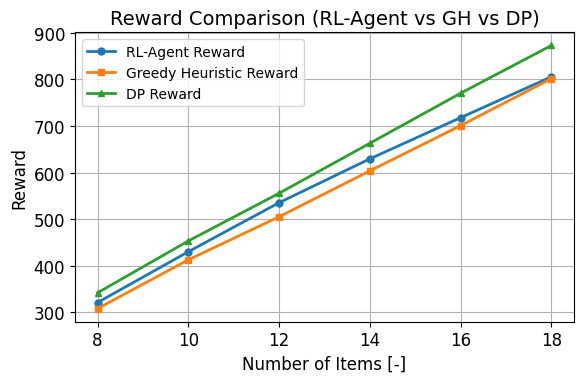

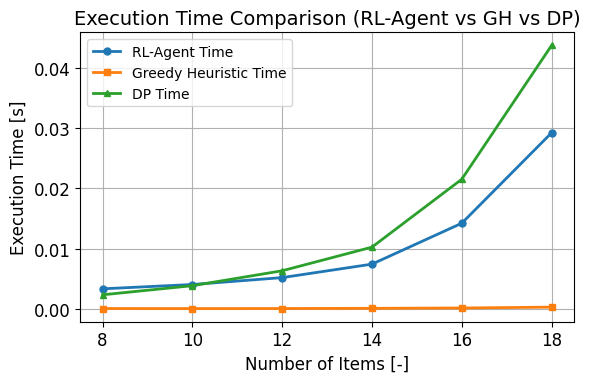

In [499]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Adjusting text size for better readability in a small image
font = {
    'size': 12  # Set font size for labels, titles, and ticks
}

plt.rc('font', **font)

# Plotting average rewards with adjusted text size and other parameters
plt.figure(figsize=(6, 4))
plt.plot(N_items_list, agent_rewards, label='RL-Agent Reward', marker='o', markersize=5, linewidth=2)
plt.plot(N_items_list, greedy_rewards, label='Greedy Heuristic Reward', marker='s', markersize=5, linewidth=2)
plt.plot(N_items_list, dp_rewards, label='DP Reward', marker='^', markersize=5, linewidth=2)
plt.xlabel('Number of Items [-]')
plt.ylabel('Reward')
plt.title('Reward Comparison (RL-Agent vs GH vs DP)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()  # Ensure everything fits within the figure
plt.show()

# Plotting average execution times with adjusted text size and other parameters
plt.figure(figsize=(6, 4))
plt.plot(N_items_list, agent_times, label='RL-Agent Time', marker='o', markersize=5, linewidth=2)
plt.plot(N_items_list, greedy_times, label='Greedy Heuristic Time', marker='s', markersize=5, linewidth=2)
plt.plot(N_items_list, dp_times, label='DP Time', marker='^', markersize=5, linewidth=2)
plt.xlabel('Number of Items [-]')
plt.ylabel('Execution Time [s]')
plt.title('Execution Time Comparison (RL-Agent vs GH vs DP)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()  # Ensure everything fits within the figure
plt.show()


In [293]:
results

{12: {'avg_agent_reward': 527.34,
  'avg_greedy_reward': 500.9,
  'avg_dp_reward': 559.16,
  'avg_agent_time': 0.004670206000082544,
  'avg_greedy_time': 4.7007999964989724e-05,
  'avg_dp_time': 0.0042222519997449125},
 14: {'avg_agent_reward': 595.1,
  'avg_greedy_reward': 606.82,
  'avg_dp_reward': 666.5,
  'avg_agent_time': 0.004431005999722401,
  'avg_greedy_time': 4.0693999908398835e-05,
  'avg_dp_time': 0.005775837999826763},
 16: {'avg_agent_reward': 677.12,
  'avg_greedy_reward': 705.51,
  'avg_dp_reward': 769.78,
  'avg_agent_time': 0.005119624000071781,
  'avg_greedy_time': 5.1365999825065954e-05,
  'avg_dp_time': 0.008125944000130402},
 18: {'avg_agent_reward': 762.93,
  'avg_greedy_reward': 797.15,
  'avg_dp_reward': 871.89,
  'avg_agent_time': 0.006351507999788737,
  'avg_greedy_time': 6.043500041414518e-05,
  'avg_dp_time': 0.010136842999781948}}